In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Literal

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    pairwise_distances
)
from sklearn.neighbors import NearestNeighbors

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# COSTANTI E TOKEN ATC

# Lunghezze standard dei livelli ATC: es. A, A10, A10B, A10BA, A10BA02
LEVEL_LENGTHS = [1, 3, 4, 5, 7]

# Token speciali
PAD_TOKEN = "<PAD>"  # usato quando un codice è più corto di un certo livello
UNK_TOKEN = "<UNK>"  # usato se troviamo un token che non è nel vocabolario

# FUNZIONI DI PRE-PROCESSING DEI CODICI ATC

def atc_to_level_tokens(code, level_lengths=LEVEL_LENGTHS):
    """
    Trasforma un codice ATC (es. 'A10BA02') in una lista di token per livello:
    ['A', 'A10', 'A10B', 'A10BA', 'A10BA02']
    """
    # Normalizziamo il codice: togliamo spazi e mettiamo maiuscolo
    # Se code e' None rimpiazza con la stringa vuota
    code_clean = (code or "").strip().upper()

    tokens = []

    # Per ogni lunghezza (1, 3, 4, 5, 7) estraiamo il prefisso
    for length in level_lengths:
        if len(code_clean) >= length:
            # se il codice è abbastanza lungo, prendo i primi length caratteri
            tokens.append(code_clean[:length])
        else:
            # se è troppo corto (es. codice solo 'A'), metto un PAD
            tokens.append(PAD_TOKEN)

    return tokens


def build_level_vocabs(atc_codes, level_lengths=LEVEL_LENGTHS):
    """
    Costruisce un vocabolario per ogni livello dell'ATC.
    ES: {'A': 0, 'B': 1, 'C': 2, '<PAD>': 3, '<UNK>': 4}
    Input: lista di codici ATC (es. colonna del dataset)
    Output: lista di dizionari [vocab_lvl1, vocab_lvl2, ..., vocab_lvl5]
    """
    # Inizializziamo un set di token per ogni livello, in questo caso 5 insiemi vuoti
    # Utilizziamo set() poiche' i duplicati NON vengono mantenuti
    level_token_sets = [set() for _ in level_lengths]

    # Per ogni codice nel dataset
    for code in atc_codes:
        # lo spezziamo in livelli
        tokens = atc_to_level_tokens(code, level_lengths)
        # e aggiungiamo ogni token al set del proprio livello
        # enumerate(tokens) fa due cose insieme: dà l'indice i (0, 1, 2, 3, 4) e il valore tok (es. "A", "A10", ...)
        for level_idx, token in enumerate(tokens):
            level_token_sets[level_idx].add(token)

    # Costruiamo i veri vocabolari (token -> indice)
    level_vocabs = []

    for token_set in level_token_sets:
        # trasformiamo il set in una lista ordinata per avere un ordine stabile in modo che se il codice venisse rieseguito
        # non cambia l'assegnazione degli indici
        all_tokens = sorted(token_set)

        # ci assicuriamo che PAD e UNK ci siano
        if PAD_TOKEN not in all_tokens:
            all_tokens.insert(0, PAD_TOKEN)
        if UNK_TOKEN not in all_tokens:
            all_tokens.insert(1, UNK_TOKEN)

        # creiamo la mappa token -> indice
        string_to_index = {tok: idx for idx, tok in enumerate(all_tokens)}
        level_vocabs.append(string_to_index)

    return level_vocabs


def encode_atc_to_level_ids(code, level_vocabs, level_lengths=LEVEL_LENGTHS):
    """
    Trasforma un codice ATC in una lista di indici interi (uno per livello).
    """
    # Spezziamo il codice in token di livello
    # Ogni tokens e' una lista di 5 stringhe
    tokens = atc_to_level_tokens(code, level_lengths)

    ids = []
    # Per ogni livello
    for i, tok in enumerate(tokens):
        vocab = level_vocabs[i]
        # Se il token è nel vocabolario, prendiamo il suo indice
        if tok in vocab:
            ids.append(vocab[tok])
        else:
            # altrimenti usiamo l'indice di UNK
            ids.append(vocab[UNK_TOKEN])

    return ids

In [ ]:
# CARICAMENTO DATASET E CREAZIONE VOCABOLARI

# Carica il dataset
atc = pd.read_csv('/content/atc_clean.csv', dtype=str).fillna("")
atc['code'] = atc['code'].astype(str).str.upper().str.strip()

# Prendi i codici unici
codes = atc['code'].tolist()

# Crea i vocabolari
level_vocabs = build_level_vocabs(codes)

# Stampa informazioni sui vocabolari
print("\nInformazioni vocabolari per livello:")
for i, vocab in enumerate(level_vocabs, start=1):
    print(f"Livello {i}: {len(vocab)} token")

print("\n")
print("Test codifica su primi 5 codici:")


# Test su 5 codici
for code in codes[:5]:
    print(code, "→", encode_atc_to_level_ids(code, level_vocabs))


Informazioni vocabolari per livello:
Livello 1: 16 token
Livello 2: 96 token
Livello 3: 271 token
Livello 4: 911 token
Livello 5: 5156 token


Test codifica su primi 5 codici:
A → [2, 0, 0, 0, 0]
B → [3, 0, 0, 0, 0]
C → [4, 0, 0, 0, 0]
D → [5, 0, 0, 0, 0]
G → [6, 0, 0, 0, 0]


In [ ]:
# MODELLO DI EMBEDDING GERARCHICO ATC

CombineMode = Literal["concat", "mean"]

# Trasformiamo un codice ATC in un vettore numerico continuo
# Esempio: A10BA02 → [0.12, -0.55, 0.77, ...] e sara' l'input per il modello
# Senza questa classe si ha solo una lista di indici
class HierarchicalATCEmbedding(nn.Module):
    def __init__(self,
                 level_vocabs,
                 level_dims,
                 combine_mode = "concat",
                 level_weights=None):
        """
        level_vocabs: lista di vocabolari (uno per livello)
        level_dims: dimensione dell'embedding per ogni livello, es. [8, 16, 16, 16, 32]. Quanti numeri avra' l'embedding di ogni livello.
        combine_mode: 'concat' -> unisce i livelli uno dopo l'altro, oppure 'mean' -> fa la media dei livelli
        level_weights: pesi opzionali per dare più importanza a un livello
        """
        super().__init__()

        # Controlliamo che il numero di livelli coincida
        assert len(level_vocabs) == len(level_dims) # level_vocabs e level_dims devono avere la stessa lunghezza

        self.num_levels = len(level_vocabs)
        self.combine_mode = combine_mode

        # pesi per livello
        if level_weights is None:
            # se non li passi, tutti i livelli valgono 1.0
            self.level_weights = [1.0] * self.num_levels
        else:
            assert len(level_weights) == self.num_levels # level_weights deve avere la stessa lunghezza di level_vocabs
            self.level_weights = level_weights

        # Creiamo una lista di nn.Embedding (tabella), uno per ogni livello
        embeddings = []
        for vocab, dim in zip(level_vocabs, level_dims):
            num_tokens = len(vocab)             # dimensione del vocabolario
            emb = nn.Embedding(num_tokens, dim) # matrice (num_tokens x dim) ogni riga rappresenta un token
            embeddings.append(emb)

        # Registriamo i layer come ModuleList (così PyTorch li vede come parametri da aggiornare durante il training)
        # Senza sarebbero variabili normali e non li aggiorna
        self.level_embeddings = nn.ModuleList(embeddings)

        # Calcoliamo la dimensione di output
        if self.combine_mode == "concat":
            # output_dim = somma delle dimensioni dei livelli poiche' si usa 'concat'
            self.output_dim = int(sum(level_dims))
        else:
            # se facciamo la media, tutte le dimensioni devono essere uguali
            assert len(set(level_dims)) == 1
            self.output_dim = int(level_dims[0])

    # Trasformiamo gli id in embedding
    def forward(self, level_ids):
        """
        level_ids: tensor intero di shape (batch_size, num_levels)
                   es. [[5,12,27,40,81],
                        [3, 9,17,25,42], ...]
        Ritorna: tensor di shape (batch_size, output_dim)
        """

        # Controlliamo che l'input abbia 2 dimensioni
        assert level_ids.dim() == 2 # level_ids deve avere shape (batch_size, num_levels)
        assert level_ids.size(1) == self.num_levels  # num_levels di input non corrisponde a quello del modello

        level_embs = []

        # Per ogni livello estraiamo gli ID e li passiamo all'embedding corrispondente
        # Esempio:
        # Livello 1: prende il numero 0 → guarda nella Tabella 1 alla riga 0 → ottiene 8 numeri
        # Livello 2: prende il numero 12 → guarda nella Tabella 2 alla riga 12 → ottiene 16 numeri
        for lvl in range(self.num_levels):
            # ids per questo livello: shape (batch_size,)
            ids_lvl = level_ids[:, lvl]
            # embedding per questo livello: shape (batch_size, dim_lvl)
            emb_lvl = self.level_embeddings[lvl](ids_lvl)
            level_embs.append(emb_lvl)

        # Combiniamo gli embedding dei vari livelli, mettendo tutti i numeri in fila, quindi tutti 88
        if self.combine_mode == "concat":
            # Applichiamo i pesi per livello prima della concatenazione
            weighted_embs = []
            for emb_lvl, w in zip(level_embs, self.level_weights):
                weighted_embs.append(emb_lvl * w)
            out = torch.cat(weighted_embs, dim=-1)
        else:
            stacked = torch.stack(level_embs, dim=1)
            out = torch.mean(stacked, dim=1)

        return out


# Dimensioni embedding per livello
level_dims = [8, 16, 16, 16, 32]

# Creiamo l'istanza del modello di embedding
atc_emb = HierarchicalATCEmbedding(
    level_vocabs=level_vocabs,
    level_dims=level_dims,
    combine_mode="concat"
)


# PREPARAZIONE INPUT PER IL TRAINING
# Addestro gli embedding affinché i vettori continui dei codici ATC imparino qualcosa di significativo e non rimangano casuali

# Converto i codici ATC in ID
all_ids = [encode_atc_to_level_ids(c, level_vocabs) for c in codes]
# Converto in tensore
all_ids_tensor = torch.tensor(all_ids, dtype=torch.long)
all_ids_tensor = all_ids_tensor.to(device)

# TRIPLET LOSS GERARCHICA


class HierarchicalTripletLoss(nn.Module):
    """
    Triplet loss "gerarchica" molto semplice.
    - Usa il prefisso ATC (ad es. primi 4 caratteri) per decidere chi è simile (positivo) e chi è diverso (negativo).
    """
    def __init__(self, margin=1.0, level_len=4):
        """
        margin: quanto vogliamo che il negativo sia più lontano del positivo
        level_len: lunghezza del prefisso ATC usato per definire la "somiglianza"
                   es: 1 -> ATC1, 3 -> ATC2, 4 -> ATC3
        """
        super().__init__()
        self.margin = margin
        self.level_len = level_len

    def forward(self, embeddings: torch.Tensor, codes: list[str]) -> torch.Tensor:
        """
        embeddings: tensor (N, dim) con gli embedding di TUTTI i codici del batch
        codes: lista di stringhe ATC corrispondente (lunghezza N)
        Ritorna: loss scalare (tensor 0-dim)
        """
        device = embeddings.device
        N = embeddings.size(0)

        total_loss = torch.tensor(0.0, device=device)
        n_triplets = 0

        # Per ogni codice del batch facciamo da "anchor"
        for i in range(N):
            anchor_emb = embeddings[i]  # vettore dell'anchor
            code_i = (codes[i] or "").strip().upper()
            prefix_i = code_i[:self.level_len]

            # Se questo codice è troppo corto (non ha quel livello), lo saltiamo
            if prefix_i == "":
                continue

            # Troviamo i POSITIVI: stessi primi 'level_len' caratteri
            positive_idx = None
            for j in range(N):
                if j == i:
                    continue
                code_j = (codes[j] or "").strip().upper()
                prefix_j = code_j[:self.level_len]
                if prefix_j == prefix_i and prefix_j != "":
                    positive_idx = j
                    break  # per semplicità prendiamo il primo che troviamo

            # Troviamo i NEGATIVI: prefisso diverso
            negative_idx = None
            for k in range(N):
                if k == i:
                    continue
                code_k = (codes[k] or "").strip().upper()
                prefix_k = code_k[:self.level_len]
                if prefix_k != "" and prefix_k != prefix_i:
                    negative_idx = k
                    break

            # Se non abbiamo trovato almeno un positivo e un negativo, saltiamo
            if positive_idx is None or negative_idx is None:
                continue

            positive_emb = embeddings[positive_idx]
            negative_emb = embeddings[negative_idx]

            # Distanze L2 (euclidee) anchor–positivo e anchor–negativo
            dist_pos = torch.norm(anchor_emb - positive_emb, p=2)
            dist_neg = torch.norm(anchor_emb - negative_emb, p=2)

            # Triplet loss classica: max(0, dist_pos - dist_neg + margin)
            loss_i = F.relu(dist_pos - dist_neg + self.margin)

            total_loss += loss_i
            n_triplets += 1

        if n_triplets == 0:
            # Nessuna tripla trovata (caso limite): ritorniamo 0
            return torch.tensor(0.0, device=device)

        # Media sulle triplette usate
        return total_loss / n_triplets

# COSTRUZIONE DELLE ETICHETTE GERARCHICHE ATC

# Estrai le etichette per 3 livelli: ATC1, ATC2, ATC3
atc1_labels = []
atc2_labels = []
atc3_labels = []

for c in codes:
    c = c.strip().upper()
    atc1_labels.append(c[0] if len(c) >= 1 else "") # Utilizziamo "" per dire che questo codice non ha un determinato livello di ATC
    atc2_labels.append(c[:3] if len(c) >= 3 else "")
    atc3_labels.append(c[:4] if len(c) >= 4 else "")


# Crea un dizionario che numera tutte le possibili classi
def build_label_vocab(labels):
    uniq = sorted(set(labels)) # Prende l'elenco di etichette e rimuove i duplicati. Ottieni una lista ordinata delle classi possibili.
    if "" in uniq:
        uniq.remove("")
    # Mappiamo a indici, creando il dizionario finale stringa e numero intero. Ogni classe avrà un ID.
    label2id = {lab: i for i, lab in enumerate(uniq)}
    return label2id


atc1_vocab = build_label_vocab(atc1_labels)
atc2_vocab = build_label_vocab(atc2_labels)
atc3_vocab = build_label_vocab(atc3_labels)


# Converte una lista di etichette stringa in una lista di indici di classe numerici utilizzando il dizionario creato prima
def map_labels_to_ids(labels, vocab):
    ids = []
    for lab in labels:
        if lab in vocab:
            ids.append(vocab[lab])
        else:
            ids.append(-1)
    return np.array(ids, dtype=np.int64)


y1 = map_labels_to_ids(atc1_labels, atc1_vocab)
y2 = map_labels_to_ids(atc2_labels, atc2_vocab)
y3 = map_labels_to_ids(atc3_labels, atc3_vocab)

y1_t = torch.tensor(y1, dtype=torch.long)
y2_t = torch.tensor(y2, dtype=torch.long)
y3_t = torch.tensor(y3, dtype=torch.long)

y1_t = y1_t.to(device)
y2_t = y2_t.to(device)
y3_t = y3_t.to(device)

print("\nNumero di classi per livello:")
print(f"  Classi ATC1: {len(atc1_vocab)}")
print(f"  Classi ATC2: {len(atc2_vocab)}")
print(f"  Classi ATC3: {len(atc3_vocab)}")

# CLASSIFICATORE GERARCHICO ATC

class ATCHierarchicalClassifier(nn.Module):
    def __init__(
        self,
        embedding_layer,
        n_atc1,
        n_atc2,
        n_atc3,
        hidden_dim=128,
        dropout=0.2,
        freeze_embedding=False,
    ):
        super().__init__()

        self.embedding = embedding_layer
        d = self.embedding.output_dim

        # opzionale: congelo gli embedding nella prima fase
        if freeze_embedding:
            for p in self.embedding.parameters():
                p.requires_grad = False

        # MLP condiviso per tutte le teste (più espressivo di una sola Linear)
        self.shared_mlp = nn.Sequential(
            nn.Linear(d, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # tre teste: ATC1, ATC2, ATC3
        self.head_atc1 = nn.Linear(hidden_dim, n_atc1)
        self.head_atc2 = nn.Linear(hidden_dim, n_atc2)
        self.head_atc3 = nn.Linear(hidden_dim, n_atc3)

    def forward(self, ids):
        # ids: (batch, num_levels)
        z = self.embedding(ids)          # (batch, d)
        h = self.shared_mlp(z)           # (batch, hidden_dim)

        logits1 = self.head_atc1(h)      # (batch, n_atc1)
        logits2 = self.head_atc2(h)      # (batch, n_atc2)
        logits3 = self.head_atc3(h)      # (batch, n_atc3)

        return logits1, logits2, logits3


model = ATCHierarchicalClassifier(
    embedding_layer=atc_emb,
    n_atc1=len(atc1_vocab),
    n_atc2=len(atc2_vocab),
    n_atc3=len(atc3_vocab),
    hidden_dim=128,
    dropout=0.2,
    freeze_embedding=False,  # se vuoi provare a congelare, metti True
)

model = model.to(device)
atc_emb = atc_emb.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1) # Funzione d'errore
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Aggiusta i pesi per ridurre l'errore


Numero di classi per livello:
  Classi ATC1: 14
  Classi ATC2: 94
  Classi ATC3: 269


In [ ]:
triplet_loss_fn = HierarchicalTripletLoss(
    margin=2.5,   # quanto forziamo la distanza negativa ad essere maggiore
    level_len=4   # usa il prefisso ATC3 (4 caratteri). Puoi provare anche 3 o 1.
)

TRIPLET_WEIGHT = 6.0

# TRAINING LOOP
n_epochs = 40

print("\n" + "="*60)
print("INIZIO TRAINING")
print("="*60)

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    # 1) Forward del modello per la classificazione
    logits1, logits2, logits3 = model(all_ids_tensor)

    loss1 = criterion(logits1, y1_t)
    loss2 = criterion(logits2, y2_t)
    loss3 = criterion(logits3, y3_t)

    # Loss di classificazione
    loss_class = 0.3 * loss1 + 0.3 * loss2 + 0.4 * loss3

    # Calcoliamo gli embedding continui per TUTTI i codici
    # (usiamo direttamente il livello di embedding che già hai)
    emb = atc_emb(all_ids_tensor)   # shape (N, dim)

    # Normalizziamo L2 gli embedding (norma = 1) per avere una geometria più stabile
    #emb_norm = F.normalize(emb, p=2, dim=1)

    # Triplet loss gerarchica sugli embedding
    loss_trip = triplet_loss_fn(emb, codes)
    #loss_trip = triplet_loss_fn(emb_norm, codes)

    # Combiniamo le due loss
    total_loss = loss_class + TRIPLET_WEIGHT * loss_trip

    total_loss.backward()
    optimizer.step()

    print(
        f"Epoch {epoch+1}/{n_epochs} "
        f"loss_tot: {total_loss.item():.4f}  "
        f"(class: {loss_class.item():.4f}, triplet: {loss_trip.item():.4f})"
    )


INIZIO TRAINING
Epoch 1/40 loss_tot: 2.3695  (class: 2.1881, triplet: 0.0302)
Epoch 2/40 loss_tot: 2.3084  (class: 2.1299, triplet: 0.0297)
Epoch 3/40 loss_tot: 2.2542  (class: 2.0785, triplet: 0.0293)
Epoch 4/40 loss_tot: 2.1983  (class: 2.0254, triplet: 0.0288)
Epoch 5/40 loss_tot: 2.1390  (class: 1.9688, triplet: 0.0284)
Epoch 6/40 loss_tot: 2.0872  (class: 1.9195, triplet: 0.0279)
Epoch 7/40 loss_tot: 2.0322  (class: 1.8671, triplet: 0.0275)
Epoch 8/40 loss_tot: 1.9783  (class: 1.8157, triplet: 0.0271)
Epoch 9/40 loss_tot: 1.9239  (class: 1.7638, triplet: 0.0267)
Epoch 10/40 loss_tot: 1.8672  (class: 1.7095, triplet: 0.0263)
Epoch 11/40 loss_tot: 1.8181  (class: 1.6628, triplet: 0.0259)
Epoch 12/40 loss_tot: 1.7661  (class: 1.6132, triplet: 0.0255)
Epoch 13/40 loss_tot: 1.7171  (class: 1.5664, triplet: 0.0251)
Epoch 14/40 loss_tot: 1.6652  (class: 1.5169, triplet: 0.0247)
Epoch 15/40 loss_tot: 1.6138  (class: 1.4677, triplet: 0.0244)
Epoch 16/40 loss_tot: 1.5601  (class: 1.4162, t

In [ ]:
# Genera embedding finali dopo il training
with torch.no_grad():
    initial_emb = atc_emb(all_ids_tensor).clone()

# Dopo il training, ottieni tutti gli embedding
model.eval()
with torch.no_grad():
    all_embeddings = atc_emb(all_ids_tensor)

print("\nShape di tutti gli embedding:", all_embeddings.shape)
print("Primi 5 embedding:")
print(all_embeddings[:5])

# Converti in numpy per analisi
all_emb_np = all_embeddings.cpu().numpy()
print("Array numpy shape:", all_emb_np.shape)


Shape di tutti gli embedding: torch.Size([6440, 88])
Primi 5 embedding:
tensor([[-0.6923, -1.4625, -1.6719, -0.1225,  0.7150, -0.8316,  0.2094,  1.1794,
         -0.4762, -0.5254, -0.4379,  0.8802, -0.1699,  0.1445, -0.8768,  0.1278,
         -0.6442, -1.5172,  1.2304, -0.8443, -0.2033, -0.3857,  0.6378,  0.1507,
          0.3963, -0.9782,  1.0095, -0.2034, -0.1787, -0.0433,  0.5654, -1.9388,
         -0.3926,  0.8797, -1.2907, -1.4193, -0.4619, -0.6559,  0.4000, -0.8080,
          1.0650, -1.7314, -0.0749, -0.5078, -0.6178, -0.6042,  0.2983, -0.0155,
         -0.0246, -0.0974,  0.3608,  0.3457,  0.0994,  0.7023, -0.8479,  1.4847,
          0.8634,  1.1892, -0.4398, -0.2143, -0.1594,  0.3691, -3.0980, -2.0898,
          0.0156,  0.5858, -0.8419, -0.6907, -0.8426,  0.8586, -0.0431, -0.4296,
          0.5930,  0.0084,  0.5861, -0.0181, -0.3960,  0.0234, -1.6007,  0.7592,
          0.0414,  0.0625,  0.5421,  1.2278,  1.2671,  0.5116, -0.3641, -1.9613],
        [-0.0336, -1.9769,  0.5959,


VISUALIZZAZIONE t-SNE


/tmp/ipython-input-3886719994.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_macro))


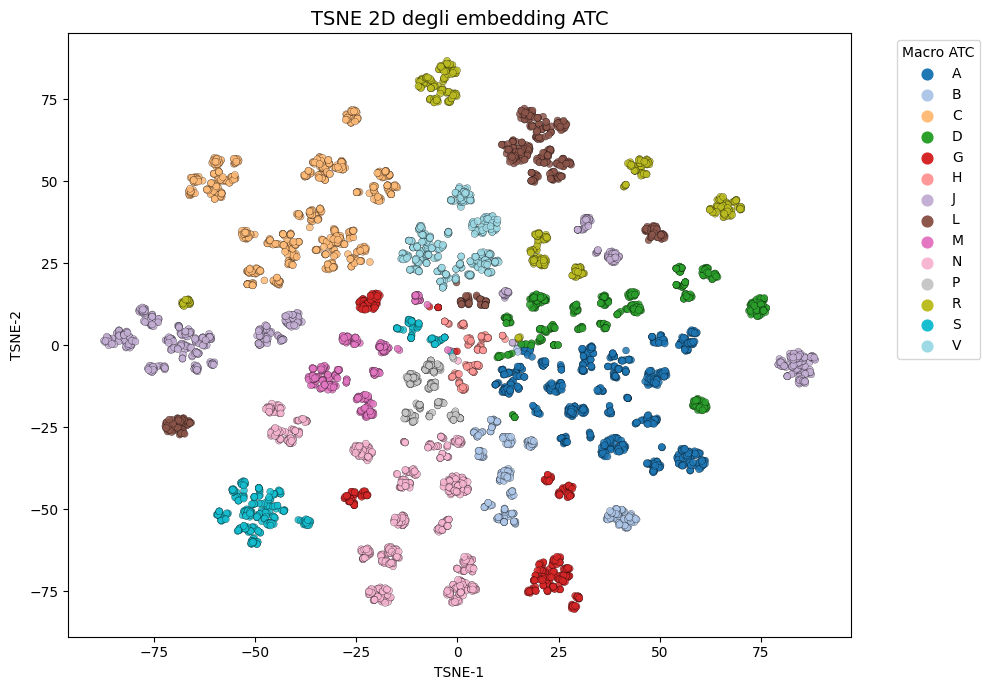


ACCURACY DEL MODELLO
Numero codici: 6440
Dimensione embedding: 88

Accuracy ATC1 (macro categoria): 0.971
Accuracy ATC2 (3 caratteri):      0.975
Accuracy ATC3 (4 caratteri):      0.958

METRICHE DI CLUSTERING

Silhouette score (macro ATC): 0.050
Davies-Bouldin index (macro ATC): 3.739
Calinski-Harabasz index (macro ATC): 103.3

K-NN SEMANTIC CONSISTENCY
K-NN consistency (macro ATC, k=10): 0.984

DISTANZE INTRA/INTER MACRO-CATEGORIA

Distanza media stessa macro ATC:  12.190
Distanza media macro diverse:     13.483

TEST GERARCHICO SULLE DISTANZE
Distanza media per stessa ATC3: 8.493
Distanza media per stessa ATC2 (ATC3 diversa): 11.088
Distanza media per stessa ATC1 (ATC2 diversa): 12.648
Distanza media per ATC1 diversa: 13.491


In [ ]:
# GENERAZIONE EMBEDDING FINALI

with torch.no_grad():
    final_emb = atc_emb(all_ids_tensor).clone()
    #final_emb = F.normalize(final_emb, p=2, dim=1)

# VISUALIZZAZIONE t-SNE DEGLI EMBEDDING

emb_np = final_emb.detach().cpu().numpy()

# Estrai macro categoria (primo carattere del codice ATC)
macro = np.array([c[0] if isinstance(c, str) and len(c) > 0 else "?" for c in codes])
unique_macro = sorted(set(macro))
macro_to_id = {m: i for i, m in enumerate(unique_macro)}
macro_ids = np.array([macro_to_id[m] for m in macro])

print("\n" + "="*60)
print("VISUALIZZAZIONE t-SNE")
print("="*60)

# Applica t-SNE per ridurre a 2 dimensioni
tsne = TSNE(n_components=2,
            perplexity=30,
            learning_rate="auto",
            init="random",
            random_state=42)
embedded_2d = tsne.fit_transform(emb_np)

# Crea il grafico
plt.figure(figsize=(10, 7))

cmap = plt.cm.get_cmap("tab20", len(unique_macro))

plt.scatter(
    embedded_2d[:, 0],
    embedded_2d[:, 1],
    c=macro_ids,
    cmap=cmap,             # palette bella e chiara
    s=25,                  # pallini più piccoli
    alpha=0.85,            # un po' di trasparenza
    edgecolors="black",    # bordino che separa i punti
    linewidth=0.2          # sottile
)

plt.title("TSNE 2D degli embedding ATC", fontsize=14)
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")

# Legenda custom con le macro categorie
for macro_label, idx in macro_to_id.items():
    color = cmap(idx)
    plt.scatter([], [], color=color,
                label=macro_label, s=60)

plt.legend(title="Macro ATC", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# VALUTAZIONE: ACCURACY DEL MODELLO

print("\n" + "="*60)
print("ACCURACY DEL MODELLO")
print("="*60)

# Embedding continuo in numpy (N, d)
emb_np = final_emb.detach().cpu().numpy()

N, d = emb_np.shape
print(f"Numero codici: {N}")
print(f"Dimensione embedding: {d}")

# Predizioni del modello
model.eval()
with torch.no_grad():
    logits1, logits2, logits3 = model(all_ids_tensor)

# Predizioni come argmax sui logit
pred_atc1 = logits1.argmax(dim=1).cpu().numpy()
pred_atc2 = logits2.argmax(dim=1).cpu().numpy()
pred_atc3 = logits3.argmax(dim=1).cpu().numpy()

# Per evitare problemi con le classi -1, filtriamo solo gli indici validi
mask1 = (y1_t >= 0).cpu().numpy()
mask2 = (y2_t >= 0).cpu().numpy()
mask3 = (y3_t >= 0).cpu().numpy()

acc1 = accuracy_score(
    y1_t[mask1].cpu().numpy(),
    pred_atc1[mask1]
)
acc2 = accuracy_score(
    y2_t[mask2].cpu().numpy(),
    pred_atc2[mask2]
)
acc3 = accuracy_score(
    y3_t[mask3].cpu().numpy(),
    pred_atc3[mask3]
)

print(f"\nAccuracy ATC1 (macro categoria): {acc1:.3f}")
print(f"Accuracy ATC2 (3 caratteri):      {acc2:.3f}")
print(f"Accuracy ATC3 (4 caratteri):      {acc3:.3f}")


# METRICHE DI CLUSTERING

print("\n" + "="*60)
print("METRICHE DI CLUSTERING")
print("="*60)

# Prepara macro-categoria come intero (ATC1)
def safe_upper(code):
    return (code or "").strip().upper()

codes_clean = [safe_upper(c) for c in codes]

macro = np.array([c[0] if len(c) > 0 else "?" for c in codes_clean])
unique_macro = sorted(set(macro))
macro_to_id = {m: i for i, m in enumerate(unique_macro)}
macro_ids = np.array([macro_to_id[m] for m in macro])

# Silhouette score per le macro categorie
sil_score = silhouette_score(emb_np, macro_ids)
print(f"\nSilhouette score (macro ATC): {sil_score:.3f}")

# Davies-Bouldin index
db_index = davies_bouldin_score(emb_np, macro_ids)
print(f"Davies-Bouldin index (macro ATC): {db_index:.3f}")

# Calinski-Harabasz index
ch_index = calinski_harabasz_score(emb_np, macro_ids)
print(f"Calinski-Harabasz index (macro ATC): {ch_index:.1f}")


# K-NN SEMANTIC CONSISTENCY

print("\n" + "="*60)
print("K-NN SEMANTIC CONSISTENCY")
print("="*60)

k = 10   # numero di vicini da considerare (escludendo se stesso)

nbrs = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(emb_np)
distances, indices = nbrs.kneighbors(emb_np)

# Per ogni punto, guardo i k vicini (escludo se stesso: indices[:,0])
same_macro_fraction = []

for i in range(N):
    neigh_idxs = indices[i, 1:]  # escludo l'indice i stesso
    frac_same = np.mean(macro_ids[neigh_idxs] == macro_ids[i])
    same_macro_fraction.append(frac_same)

knn_consistency = np.mean(same_macro_fraction)
print(f"K-NN consistency (macro ATC, k={k}): {knn_consistency:.3f}")


# DISTANZE INTRA/INTER MACRO-CATEGORIA

print("\n" + "="*60)
print("DISTANZE INTRA/INTER MACRO-CATEGORIA")
print("="*60)

# Per evitare complessità O(N^2) troppo grande, campioniamo al massimo 2000 punti
max_samples = 2000
if N > max_samples:
    idx_sample = np.random.choice(N, size=max_samples, replace=False)
    emb_sample = emb_np[idx_sample]
    macro_sample = macro_ids[idx_sample]
else:
    emb_sample = emb_np
    macro_sample = macro_ids

# Matrice di distanze pairwise
D = pairwise_distances(emb_sample, metric="euclidean")

# Maschere booleane
same_macro = macro_sample[:, None] == macro_sample[None, :]
diff_macro = ~same_macro

# Escludo la diagonale (distanza di un punto con se stesso)
np.fill_diagonal(D, np.nan)
same_macro[np.eye(len(emb_sample), dtype=bool)] = False
diff_macro[np.eye(len(emb_sample), dtype=bool)] = False

intra_dist = np.nanmean(D[same_macro])
inter_dist = np.nanmean(D[diff_macro])

print(f"\nDistanza media stessa macro ATC:  {intra_dist:.3f}")
print(f"Distanza media macro diverse:     {inter_dist:.3f}")


# TEST GERARCHICO SULLE DISTANZE (ATC1/ATC2/ATC3)

print("\n" + "="*60)
print("TEST GERARCHICO SULLE DISTANZE")
print("="*60)

# Converto etichette in numpy array
atc1_arr = np.array(atc1_labels)
atc2_arr = np.array(atc2_labels)
atc3_arr = np.array(atc3_labels)

# Per semplicità, uso lo stesso campione di prima
M = emb_sample.shape[0]
idx = np.arange(M)

# Creo alcune coppie random per ognuna delle condizioni
def sample_pairs(mask, n_pairs=5000):
    """mask è una matrice booleana (M, M) che indica quali coppie rispettano la condizione."""
    i_idx, j_idx = np.where(mask)
    if len(i_idx) == 0:
        return np.array([]), np.array([])
    n = min(n_pairs, len(i_idx))
    sel = np.random.choice(len(i_idx), size=n, replace=False)
    return i_idx[sel], j_idx[sel]

# Rinnovo macro, atc2, atc3 per il sottoinsieme campionato
atc1_s = atc1_arr[idx_sample] if N > max_samples else atc1_arr
atc2_s = atc2_arr[idx_sample] if N > max_samples else atc2_arr
atc3_s = atc3_arr[idx_sample] if N > max_samples else atc3_arr

# Condizioni
same_atc3 = (atc3_s[:,None] != "") & (atc3_s[:,None] == atc3_s[None,:])
same_atc2 = (atc2_s[:,None] != "") & (atc2_s[:,None] == atc2_s[None,:])
same_atc1 = (atc1_s[:,None] != "") & (atc1_s[:,None] == atc1_s[None,:])

# Maschere disgiunte:
# 1) stessa ATC3
mask_3 = same_atc3.copy()

# 2) stessa ATC2 ma ATC3 diversa
mask_2 = same_atc2 & ~same_atc3

# 3) stessa ATC1 ma ATC2 diversa
mask_1 = same_atc1 & ~same_atc2

# 4) ATC1 diversa
mask_0 = ~same_atc1

def avg_dist_for_mask(mask_name, mask_matrix):
    i_idx, j_idx = sample_pairs(mask_matrix)
    if len(i_idx) == 0:
        print(f"Nessuna coppia valida per {mask_name}")
        return np.nan
    dists = np.linalg.norm(emb_sample[i_idx] - emb_sample[j_idx], axis=1)
    mean_dist = dists.mean()
    print(f"Distanza media per {mask_name}: {mean_dist:.3f}")
    return mean_dist

d3 = avg_dist_for_mask("stessa ATC3", mask_3)
d2 = avg_dist_for_mask("stessa ATC2 (ATC3 diversa)", mask_2)
d1 = avg_dist_for_mask("stessa ATC1 (ATC2 diversa)", mask_1)
d0 = avg_dist_for_mask("ATC1 diversa", mask_0)